In [46]:
# azureml-core of version 1.0.72 or higher is required
"""from azureml.core import Workspace, Dataset

subscription_id = 'e3d40f50-727b-419f-ae16-af0880e201e1'
resource_group = 'One'
workspace_name = 'trial123'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Covid19CTSCAN')
dataset.download(target_path='.', overwrite=True)"""

"from azureml.core import Workspace, Dataset\n\nsubscription_id = 'e3d40f50-727b-419f-ae16-af0880e201e1'\nresource_group = 'One'\nworkspace_name = 'trial123'\n\nworkspace = Workspace(subscription_id, resource_group, workspace_name)\n\ndataset = Dataset.get_by_name(workspace, name='Covid19CTSCAN')\ndataset.download(target_path='.', overwrite=True)"

In [47]:
"""import zipfile
with zipfile.ZipFile("covid.zip", 'r') as zip_ref:
    zip_ref.extractall("")"""

'import zipfile\nwith zipfile.ZipFile("covid.zip", \'r\') as zip_ref:\n    zip_ref.extractall("")'

In [70]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf



In [71]:
disease_types=['COVID', 'non-COVID']
data_dir = ''
train_dir = os.path.join(data_dir)

In [72]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [73]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [74]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [04:14,  9.76it/s]


(2481, 64, 64, 3)


In [75]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
model = Sequential()
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [90]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [91]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)

training_datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(train_generator,
               steps_per_epoch=30,
               epochs=100,
               verbose=1,
               validation_data=(X_val, Y_val))

Epoch 1/100
30/30 [==============================] - 10s 347ms/step - loss: 3493.7046 - accuracy: 0.4796 - val_loss: 1.9999 - val_accuracy: 0.4859
Epoch 2/100
30/30 [==============================] - 6s 193ms/step - loss: 10.3642 - accuracy: 0.5131 - val_loss: 479.3331 - val_accuracy: 0.4739
Epoch 3/100
30/30 [==============================] - 5s 176ms/step - loss: 0.7235 - accuracy: 0.4844 - val_loss: 749.4585 - val_accuracy: 0.5060
Epoch 4/100
30/30 [==============================] - 5s 177ms/step - loss: 0.7022 - accuracy: 0.4990 - val_loss: 27.6954 - val_accuracy: 0.5060
Epoch 5/100
30/30 [==============================] - 5s 177ms/step - loss: 4584.1464 - accuracy: 0.4974 - val_loss: 857.3862 - val_accuracy: 0.5060
Epoch 6/100
30/30 [==============================] - 5s 176ms/step - loss: 3094.0429 - accuracy: 0.4874 - val_loss: 2225.9775 - val_accuracy: 0.4940
Epoch 7/100
30/30 [==============================] - 5s 176ms/step - loss: 6616.5028 - accuracy: 0.4953 - val_loss: 3.721

Epoch 58/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6960 - accuracy: 0.4806 - val_loss: 0.6935 - val_accuracy: 0.5060
Epoch 59/100
30/30 [==============================] - 5s 175ms/step - loss: 0.6951 - accuracy: 0.4854 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 60/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6933 - accuracy: 0.5058 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 61/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6925 - accuracy: 0.5078 - val_loss: 0.6995 - val_accuracy: 0.5060
Epoch 62/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6973 - accuracy: 0.5047 - val_loss: 0.6959 - val_accuracy: 0.4940
Epoch 63/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6946 - accuracy: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.5060
Epoch 64/100
30/30 [==============================] - 5s 176ms/step - loss: 0.6942 - accuracy: 0.4927 - val_loss: 0.6931 - val_accuracy:

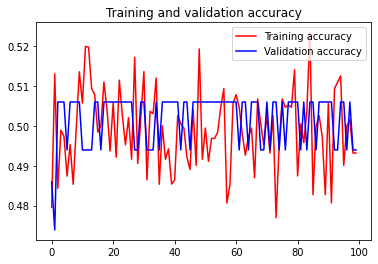

<Figure size 432x288 with 0 Axes>

In [94]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()